In [2]:
from utils.Auger.SD import Monitoring

09:11:27 (+6444.0s) [INFO   ] -- import logging
09:11:27 (    +2ms) [INFO   ] -- import numpy as np
09:11:27 (    +5ms) [INFO   ] -- import uncertainties
09:11:27 (    +2ms) [INFO   ] -- import numpy as np
09:11:27 (    +5ms) [INFO   ] -- import uncertainties
09:11:28 (  +203ms) [INFO   ] -- import pandas as pd
09:11:28 (    +2ms) [WARNING] -- pandas support to be dropped at some point!
09:11:28 (    +1ms) [INFO   ] -- import binaries.tools as tools


In [3]:
monitoring = Monitoring.Monit('/cr/data01/filip/Data/daqIntegrationTests/v14/mc_2024_09_16_07h20.root')

09:11:29 (   +1.0s) [INFO   ] -- received 1 file(s) as input
09:11:29 (  +151ms) [INFO   ] -- View monit keys with self.keys()


In [4]:
monitoring.keys()

{
  "TObject": {
    "fUniqueID": "TObject/fUniqueID",
    "fBits": "TObject/fBits"
  },
  "fLsId": "fLsId",
  "fTime": "fTime",
  "fCDASTime": "fCDASTime",
  "fMonitoring": {
    "fIsMonitoring": "fMonitoring/fMonitoring.fIsMonitoring",
    "fIsUUB": "fMonitoring/fMonitoring.fIsUUB",
    "fPMV": "fMonitoring/fMonitoring.fPMV[3]",
    "fPMI": "fMonitoring/fMonitoring.fPMI[3]",
    "fPMT": "fMonitoring/fMonitoring.fPMT[3]",
    "fElectT": "fMonitoring/fMonitoring.fElectT",
    "fBatteryT[2]": "fMonitoring/fMonitoring.fBatteryT[2]",
    "fBatteryV[2]": "fMonitoring/fMonitoring.fBatteryV[2]",
    "fCurrentLoad": "fMonitoring/fMonitoring.fCurrentLoad",
    "fSolarPanelV": "fMonitoring/fMonitoring.fSolarPanelV",
    "fSolarPanelI": "fMonitoring/fMonitoring.fSolarPanelI",
    "fWaterLevel": "fMonitoring/fMonitoring.fWaterLevel",
    "fWaterT": "fMonitoring/fMonitoring.fWaterT",
    "f12VRadio": "fMonitoring/fMonitoring.f12VRadio",
    "f3V": "fMonitoring/fMonitoring.f3V",
    "f_3V": "fMonit

In [5]:
t = monitoring('fTime', 136)
vem = monitoring('fPeak', 136)
t70 = monitoring('f70HzRate', 136)
mask = [True if v[-1] != 0 else False for v in vem]
# mask = [True for v in vem]

09:11:38 (   +9.0s) [INFO   ] -- found 225 entries for key fTime and station #136
09:11:38 (    +9ms) [INFO   ] -- found 225 entries for key fPeak and station #136
09:11:38 (   +22ms) [INFO   ] -- found 225 entries for key f70HzRate and station #136


09:11:41 (   +3.2s) [INFO   ] -- import matplotlib.pyplot as plt
09:11:41 (  +334ms) [INFO   ] -- import seaborn as so
09:11:41 (    +2ms) [INFO   ] -- import plotting.tools as plot
09:11:41 (    +6ms) [DEBUG  ] -- font size set to 9.5
09:11:41 (    +1ms) [DEBUG  ] -- label size set to 13.0
09:11:41 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
09:11:41 (    +1ms) [DEBUG  ] -- markersize set to 2.0
09:11:41 (    +0ms) [DEBUG  ] -- usetex set to False


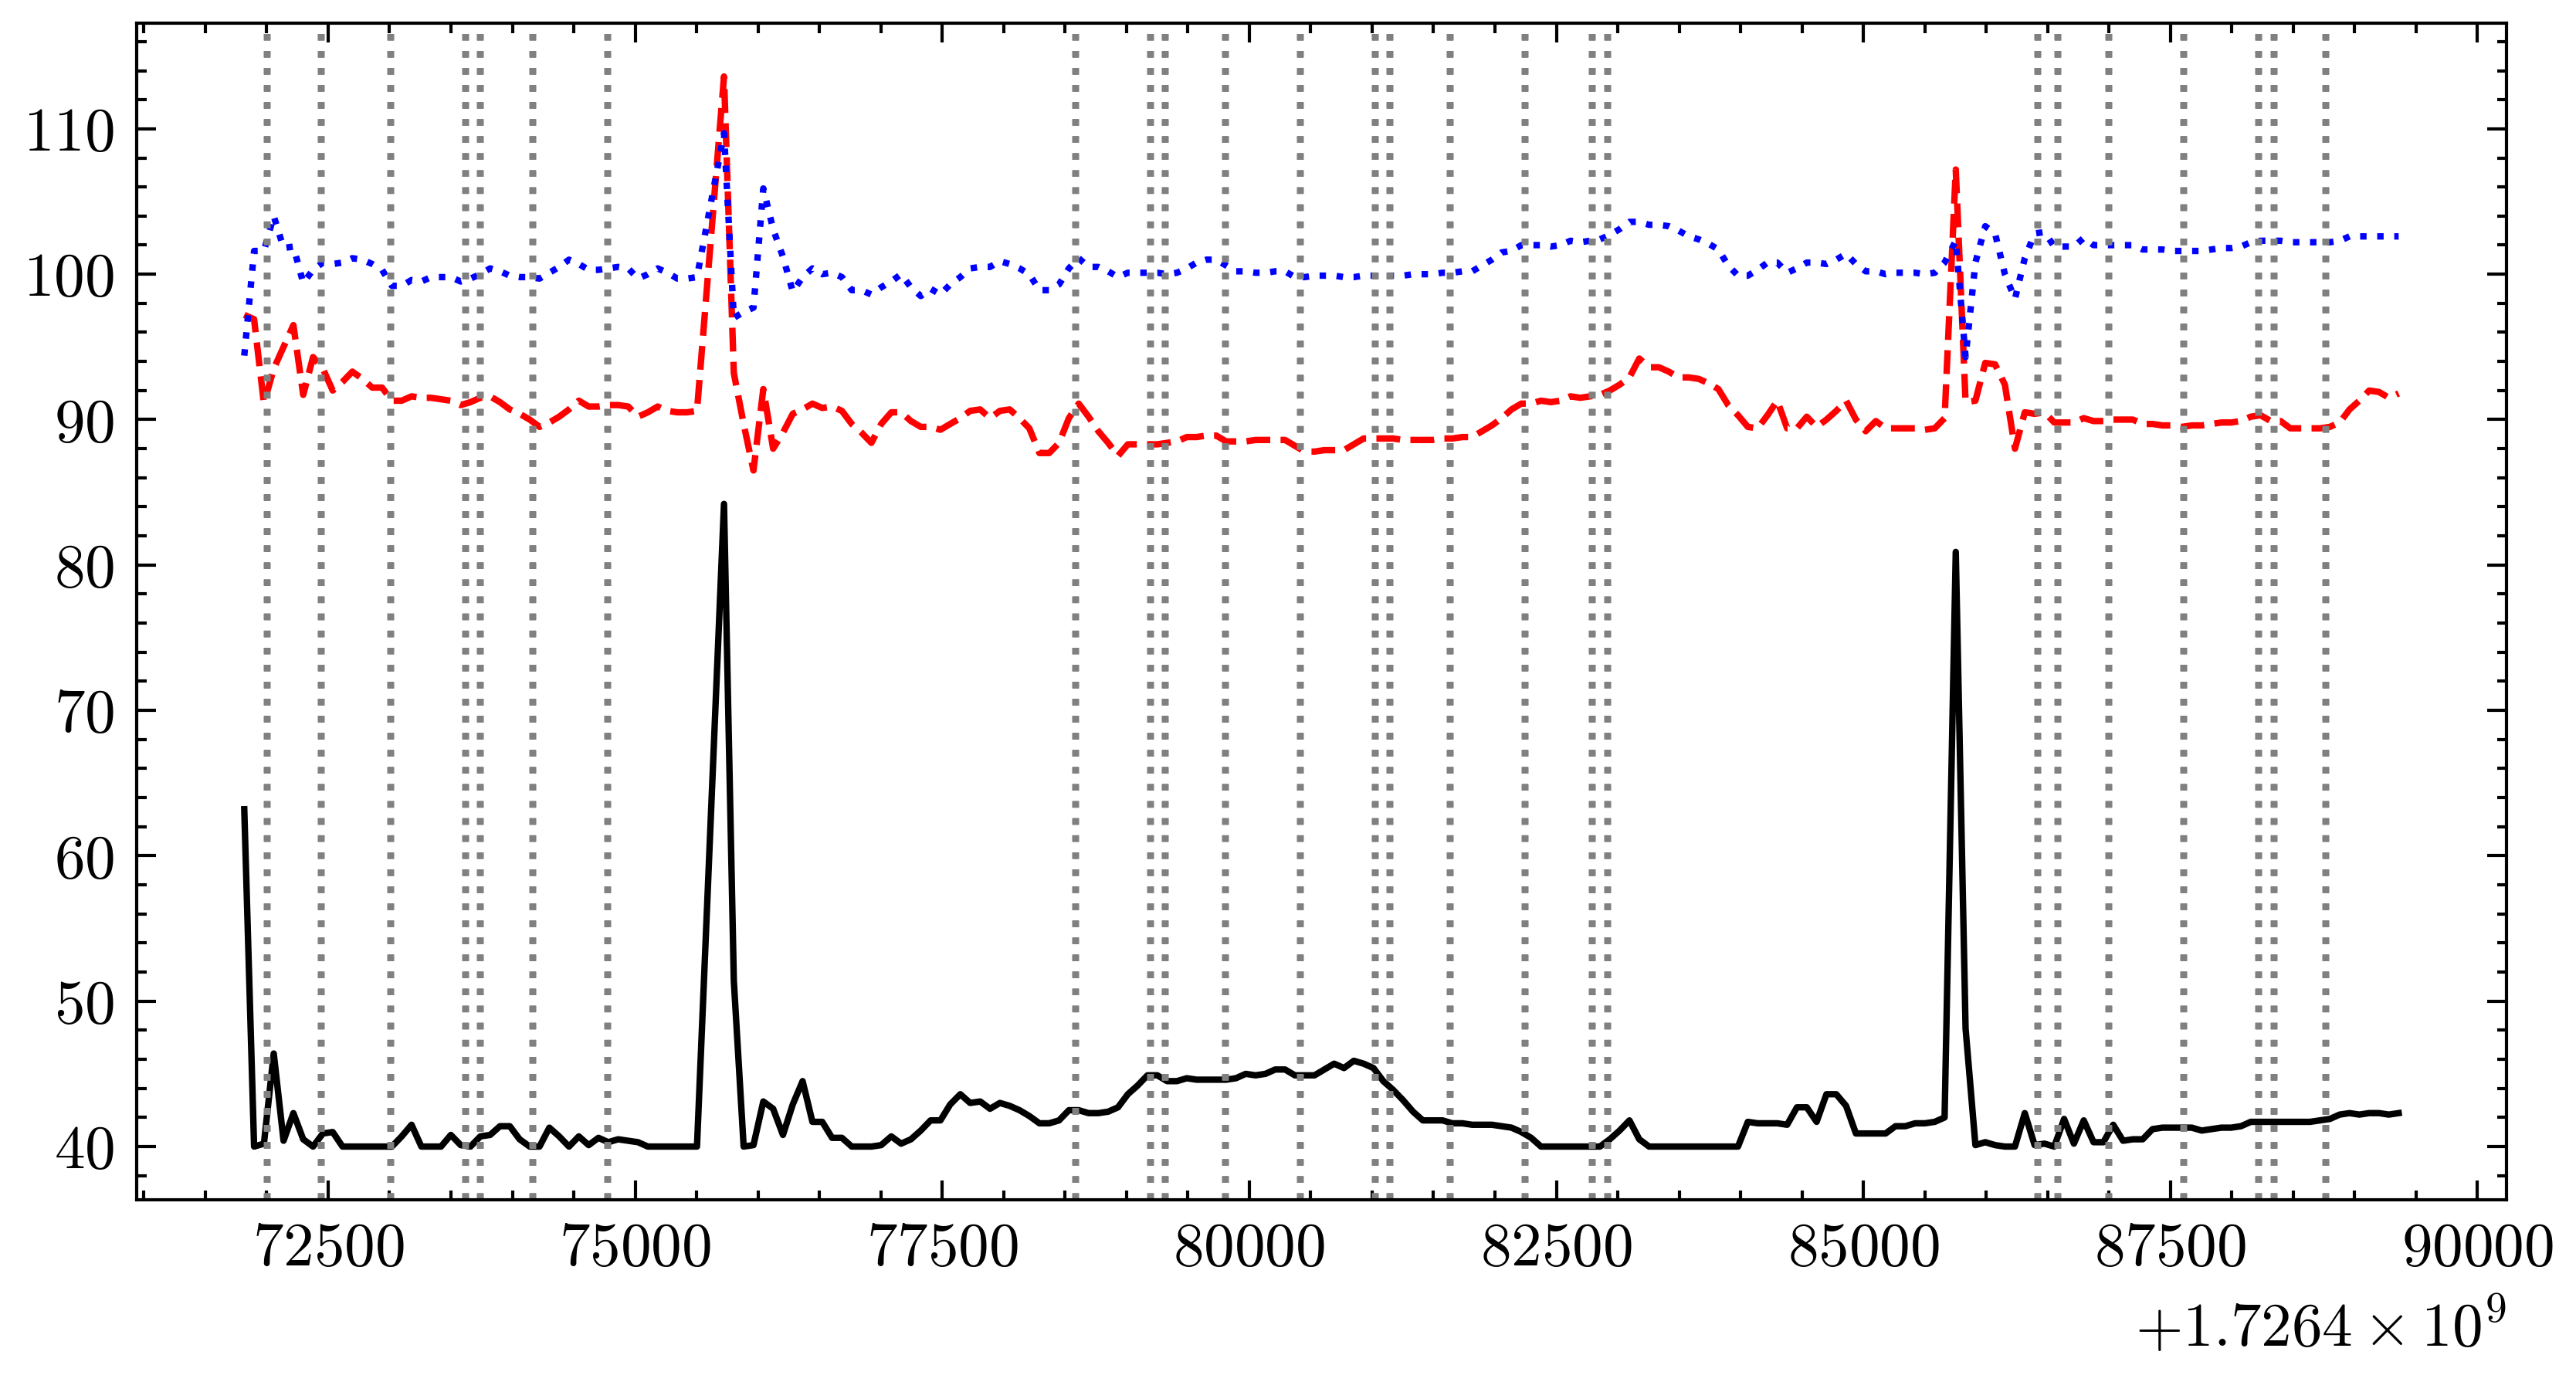

In [6]:
from utils.binaries import *
from utils.plotting import *
from utils import CONSTANTS

id, time, *histo = np.loadtxt('/cr/data01/filip/Data/daqIntegrationTests/v14/out.txt', unpack=True)
plt.plot(t[mask], vem[mask])

for ts in time:
    plt.axvline(ts + CONSTANTS.GPS_OFFSET, c='gray', ls=':')

# plt.axvline(1410518115 + CONSTANTS.GPS_OFFSET)
# plt.axvline(1410517444 + CONSTANTS.GPS_OFFSET)

In [7]:
import polars as pl

histos = pl.read_csv('/cr/data01/filip/Data/daqIntegrationTests/v14/out.txt', separator=' ', new_columns=['id', 't', 'pmt'] + [str(_) for _ in range(151)])
histos.drop_in_place('150')
histos = histos.with_columns(
    pl.concat_list(pl.col('*')
                   .exclude('id', 't', 'pmt'))
                   .alias('histo')
).select('t', 'pmt', 'histo')

ssds_histos = histos.filter(pl.col('pmt') == 3)
wcd3_histos = histos.filter(pl.col('pmt') == 2)
wcd2_histos = histos.filter(pl.col('pmt') == 1)
wcd1_histos = histos.filter(pl.col('pmt') == 0)

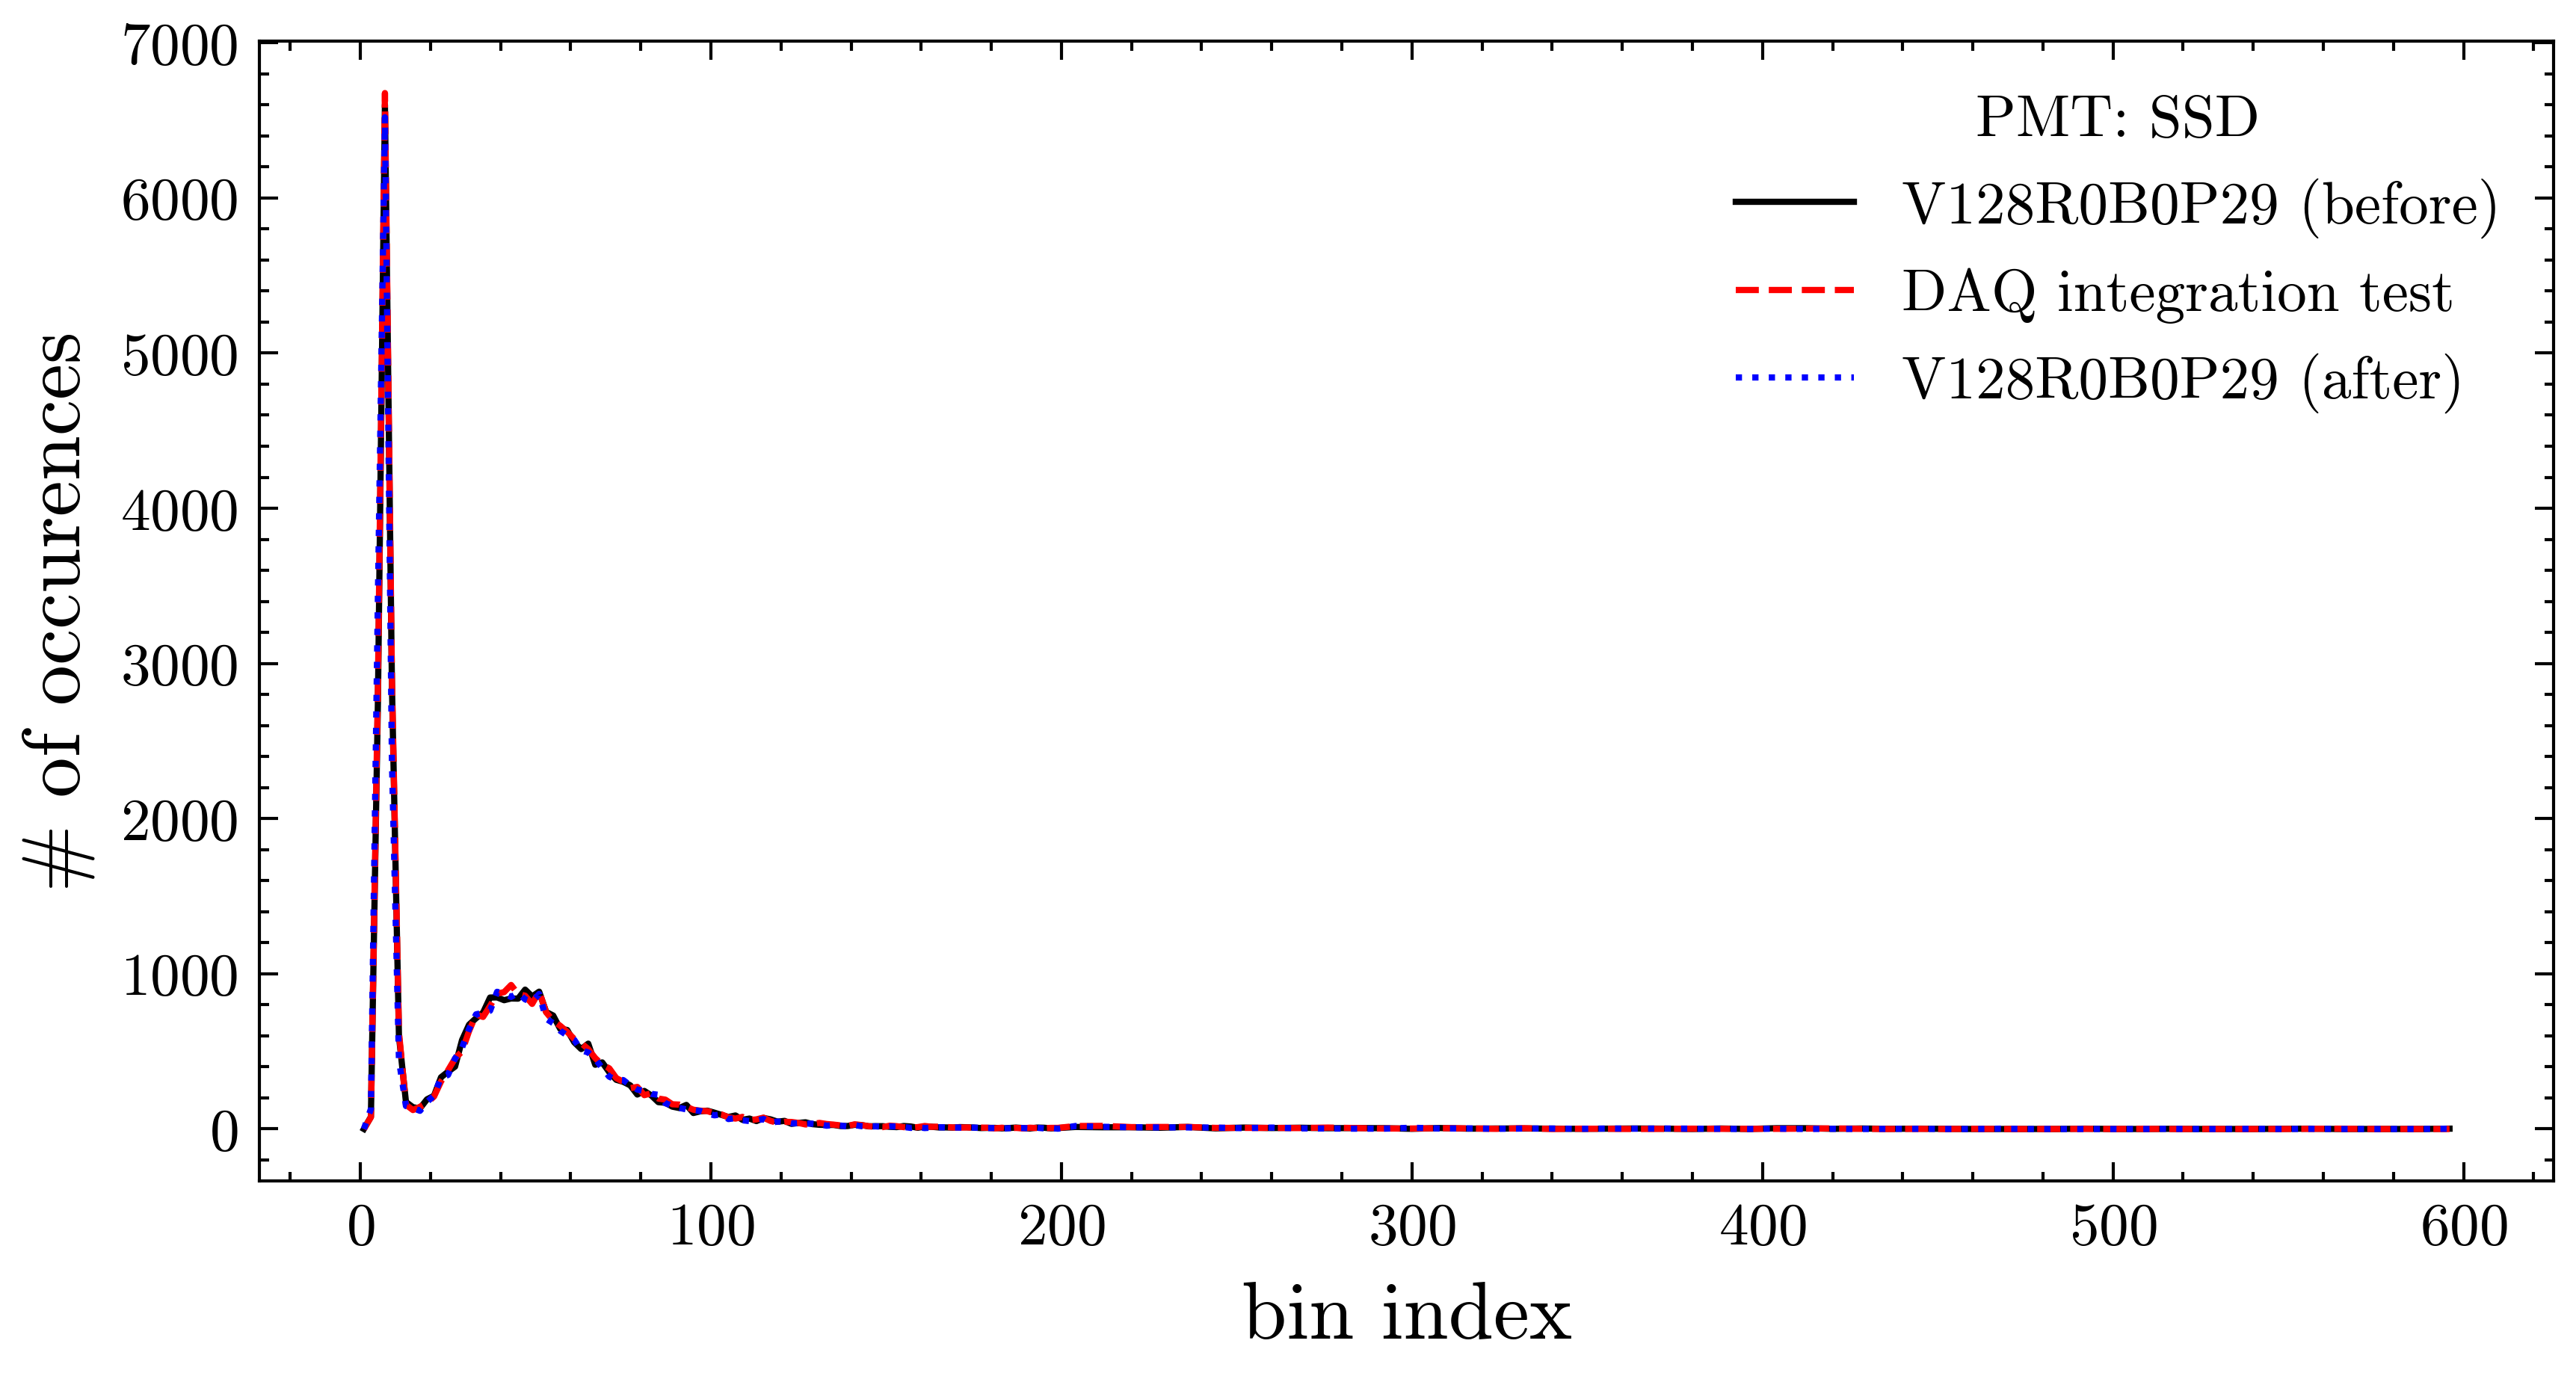

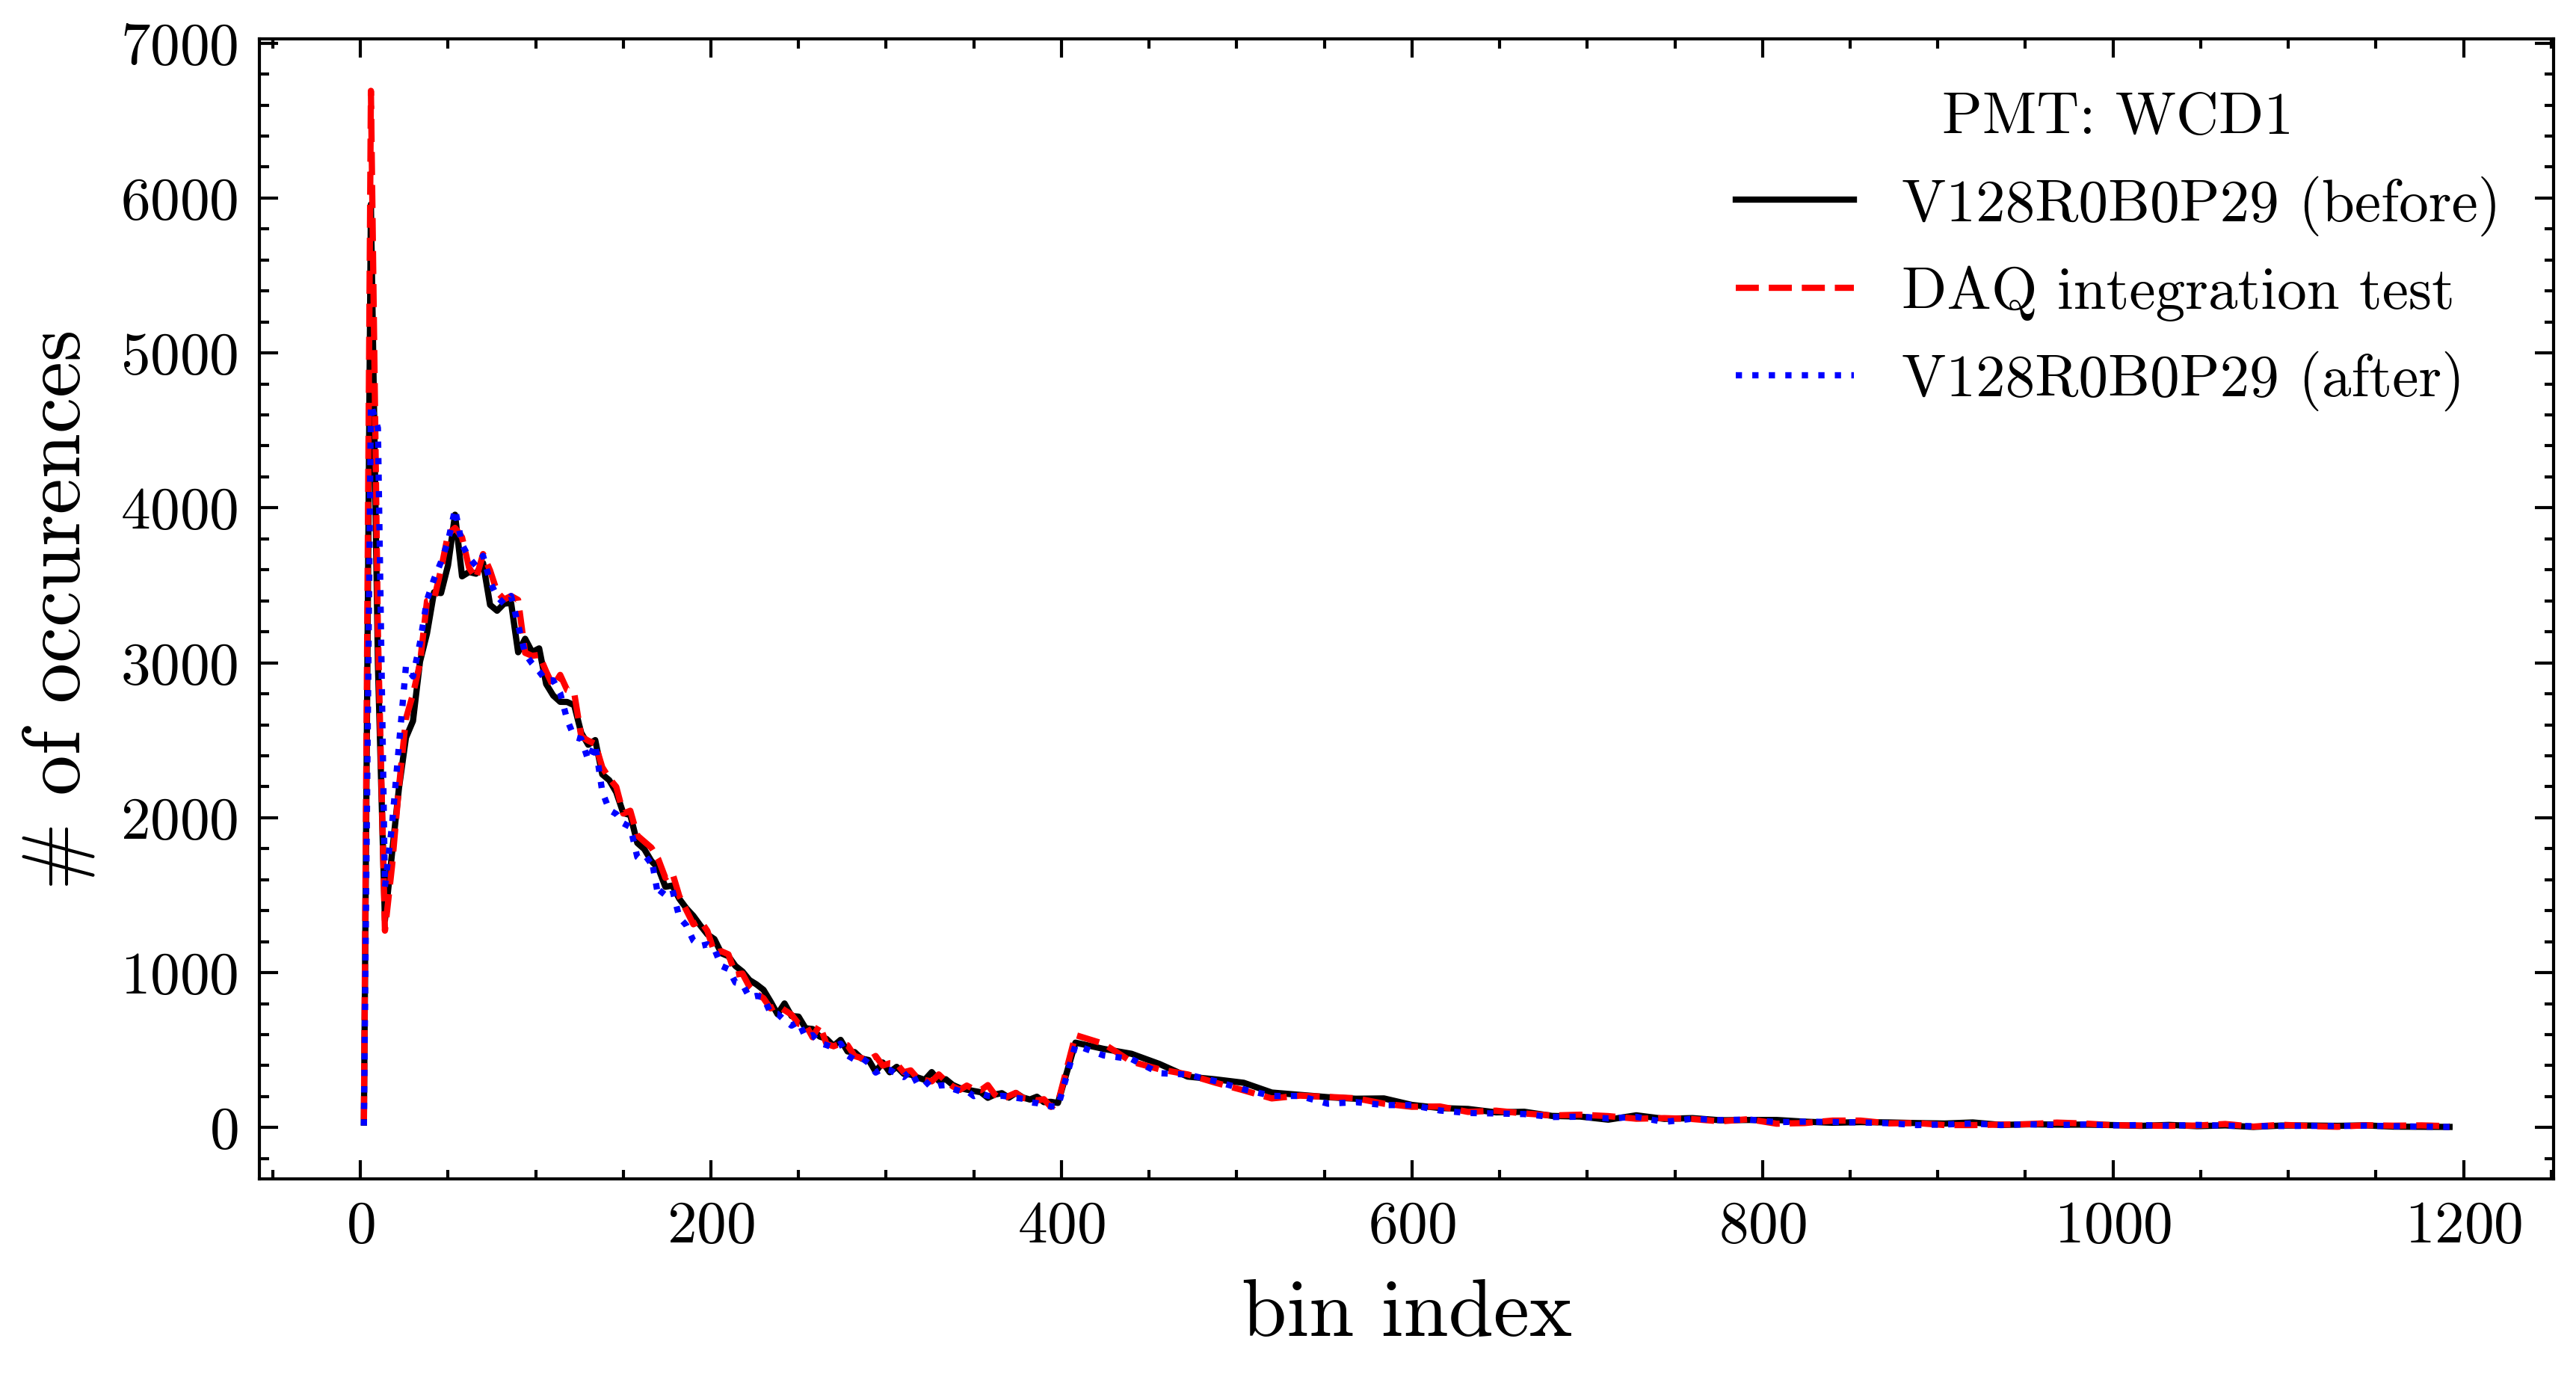

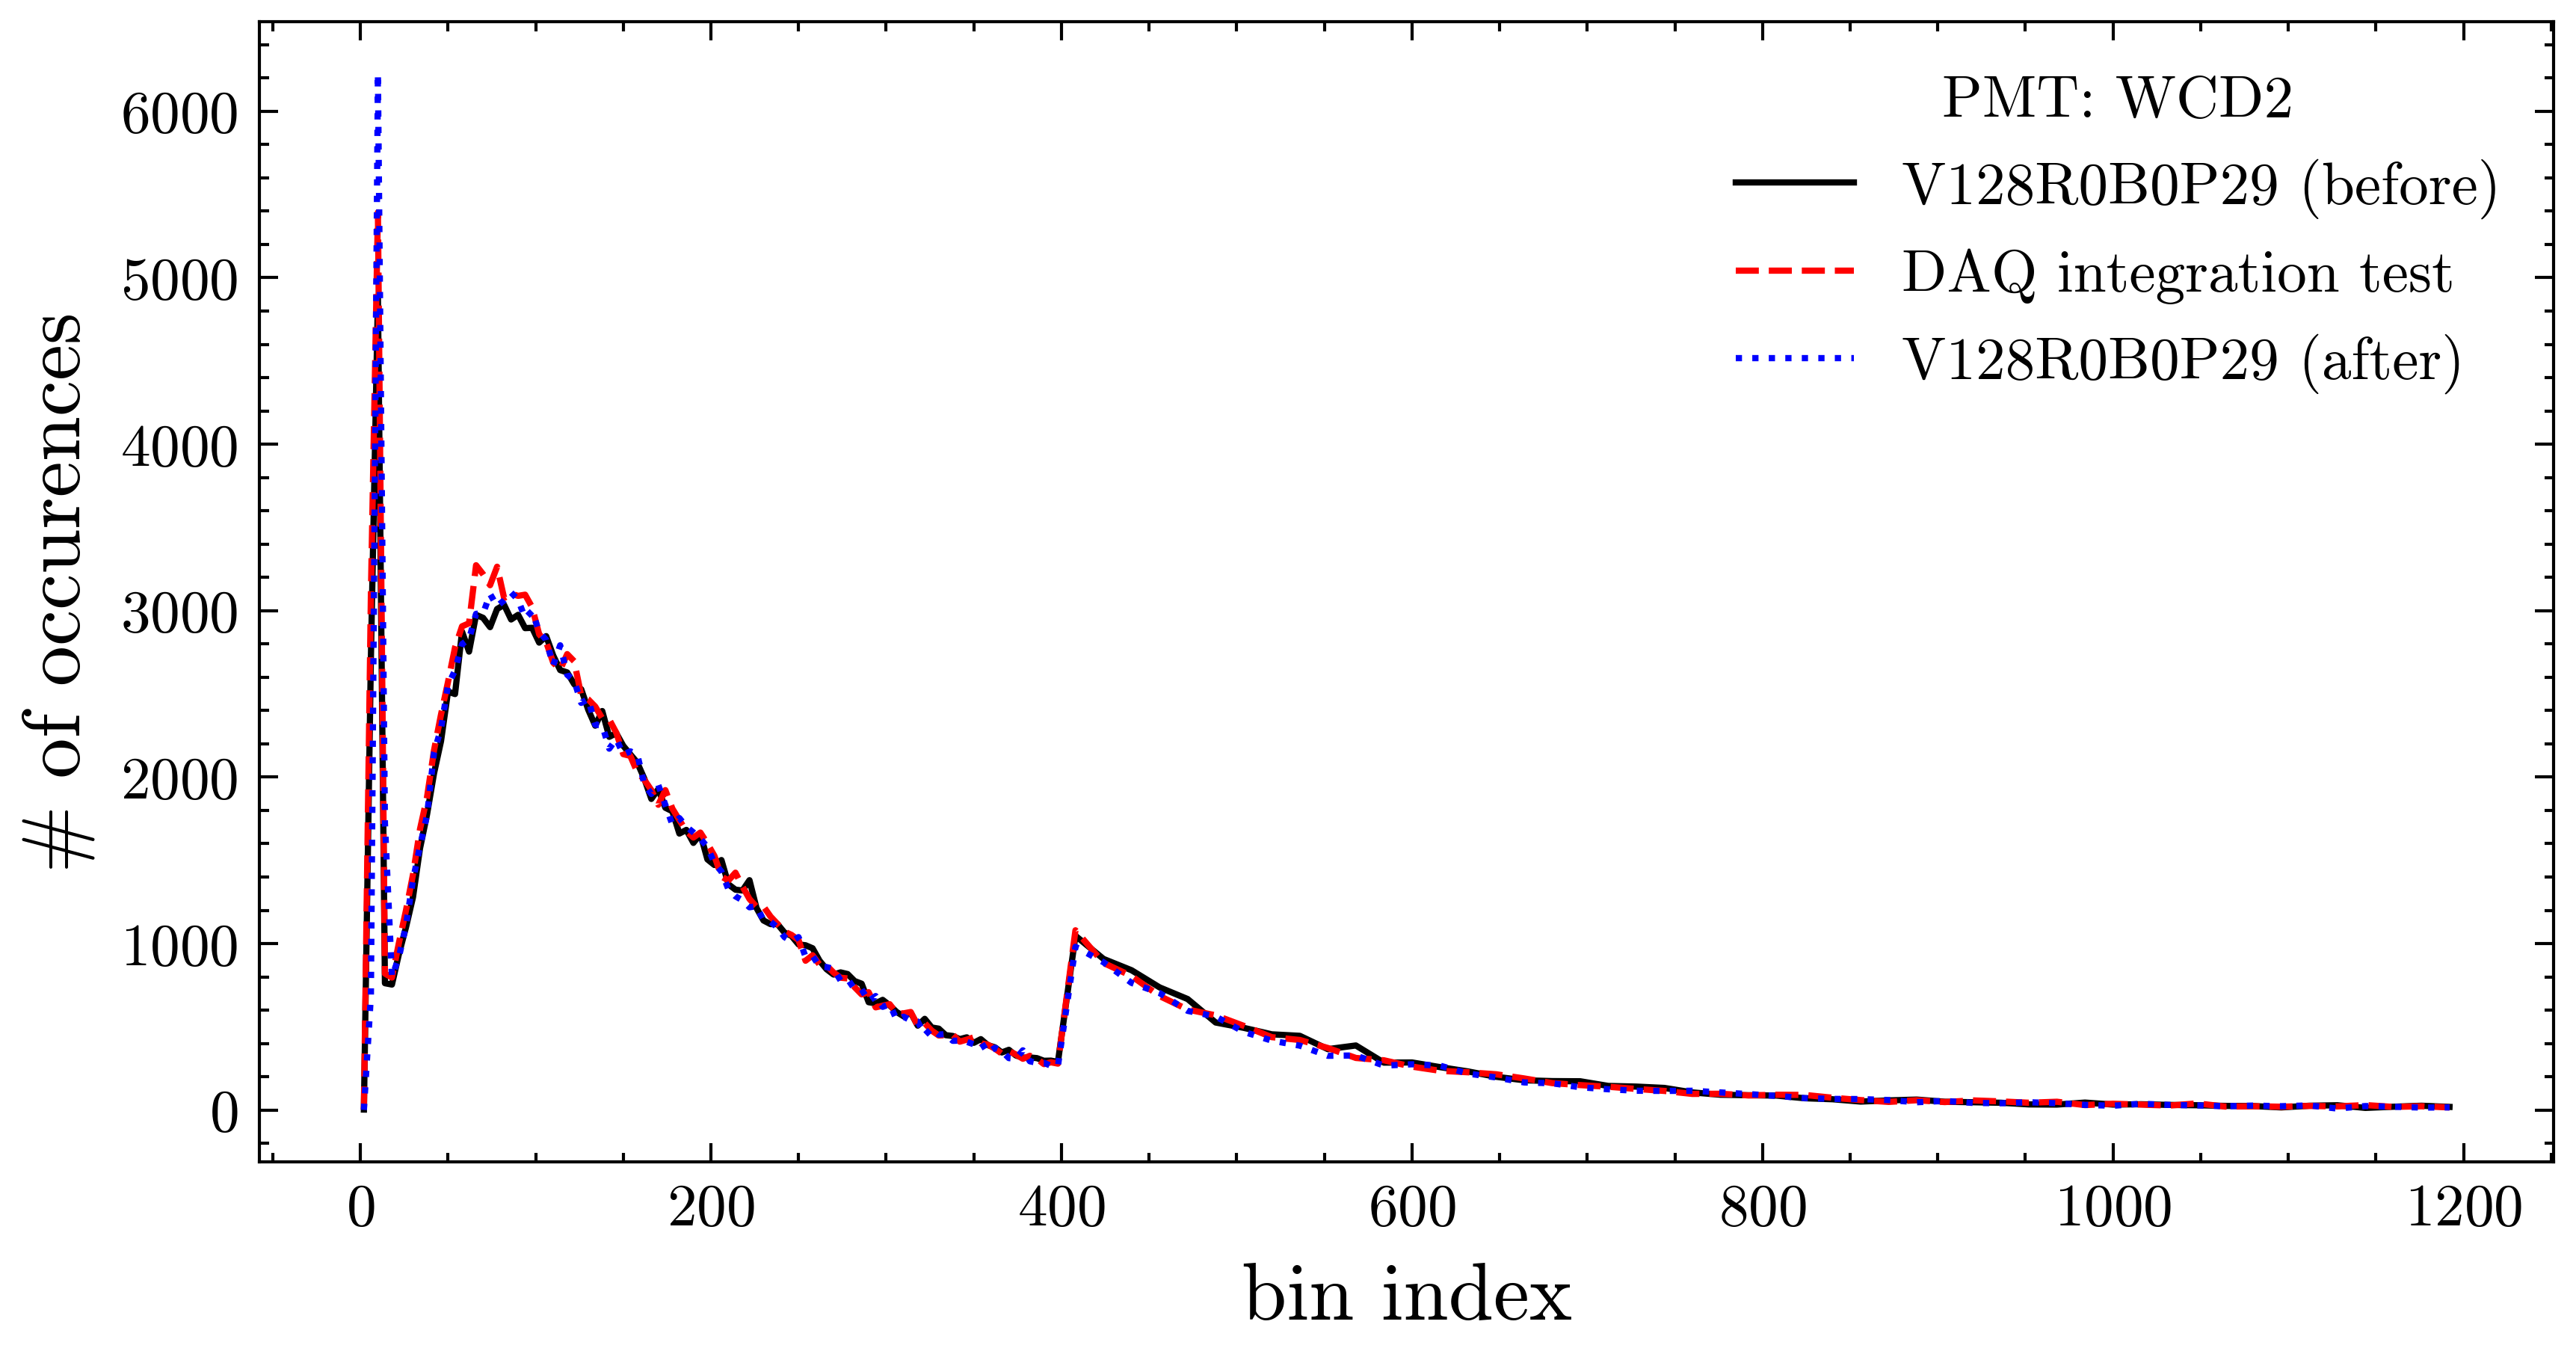

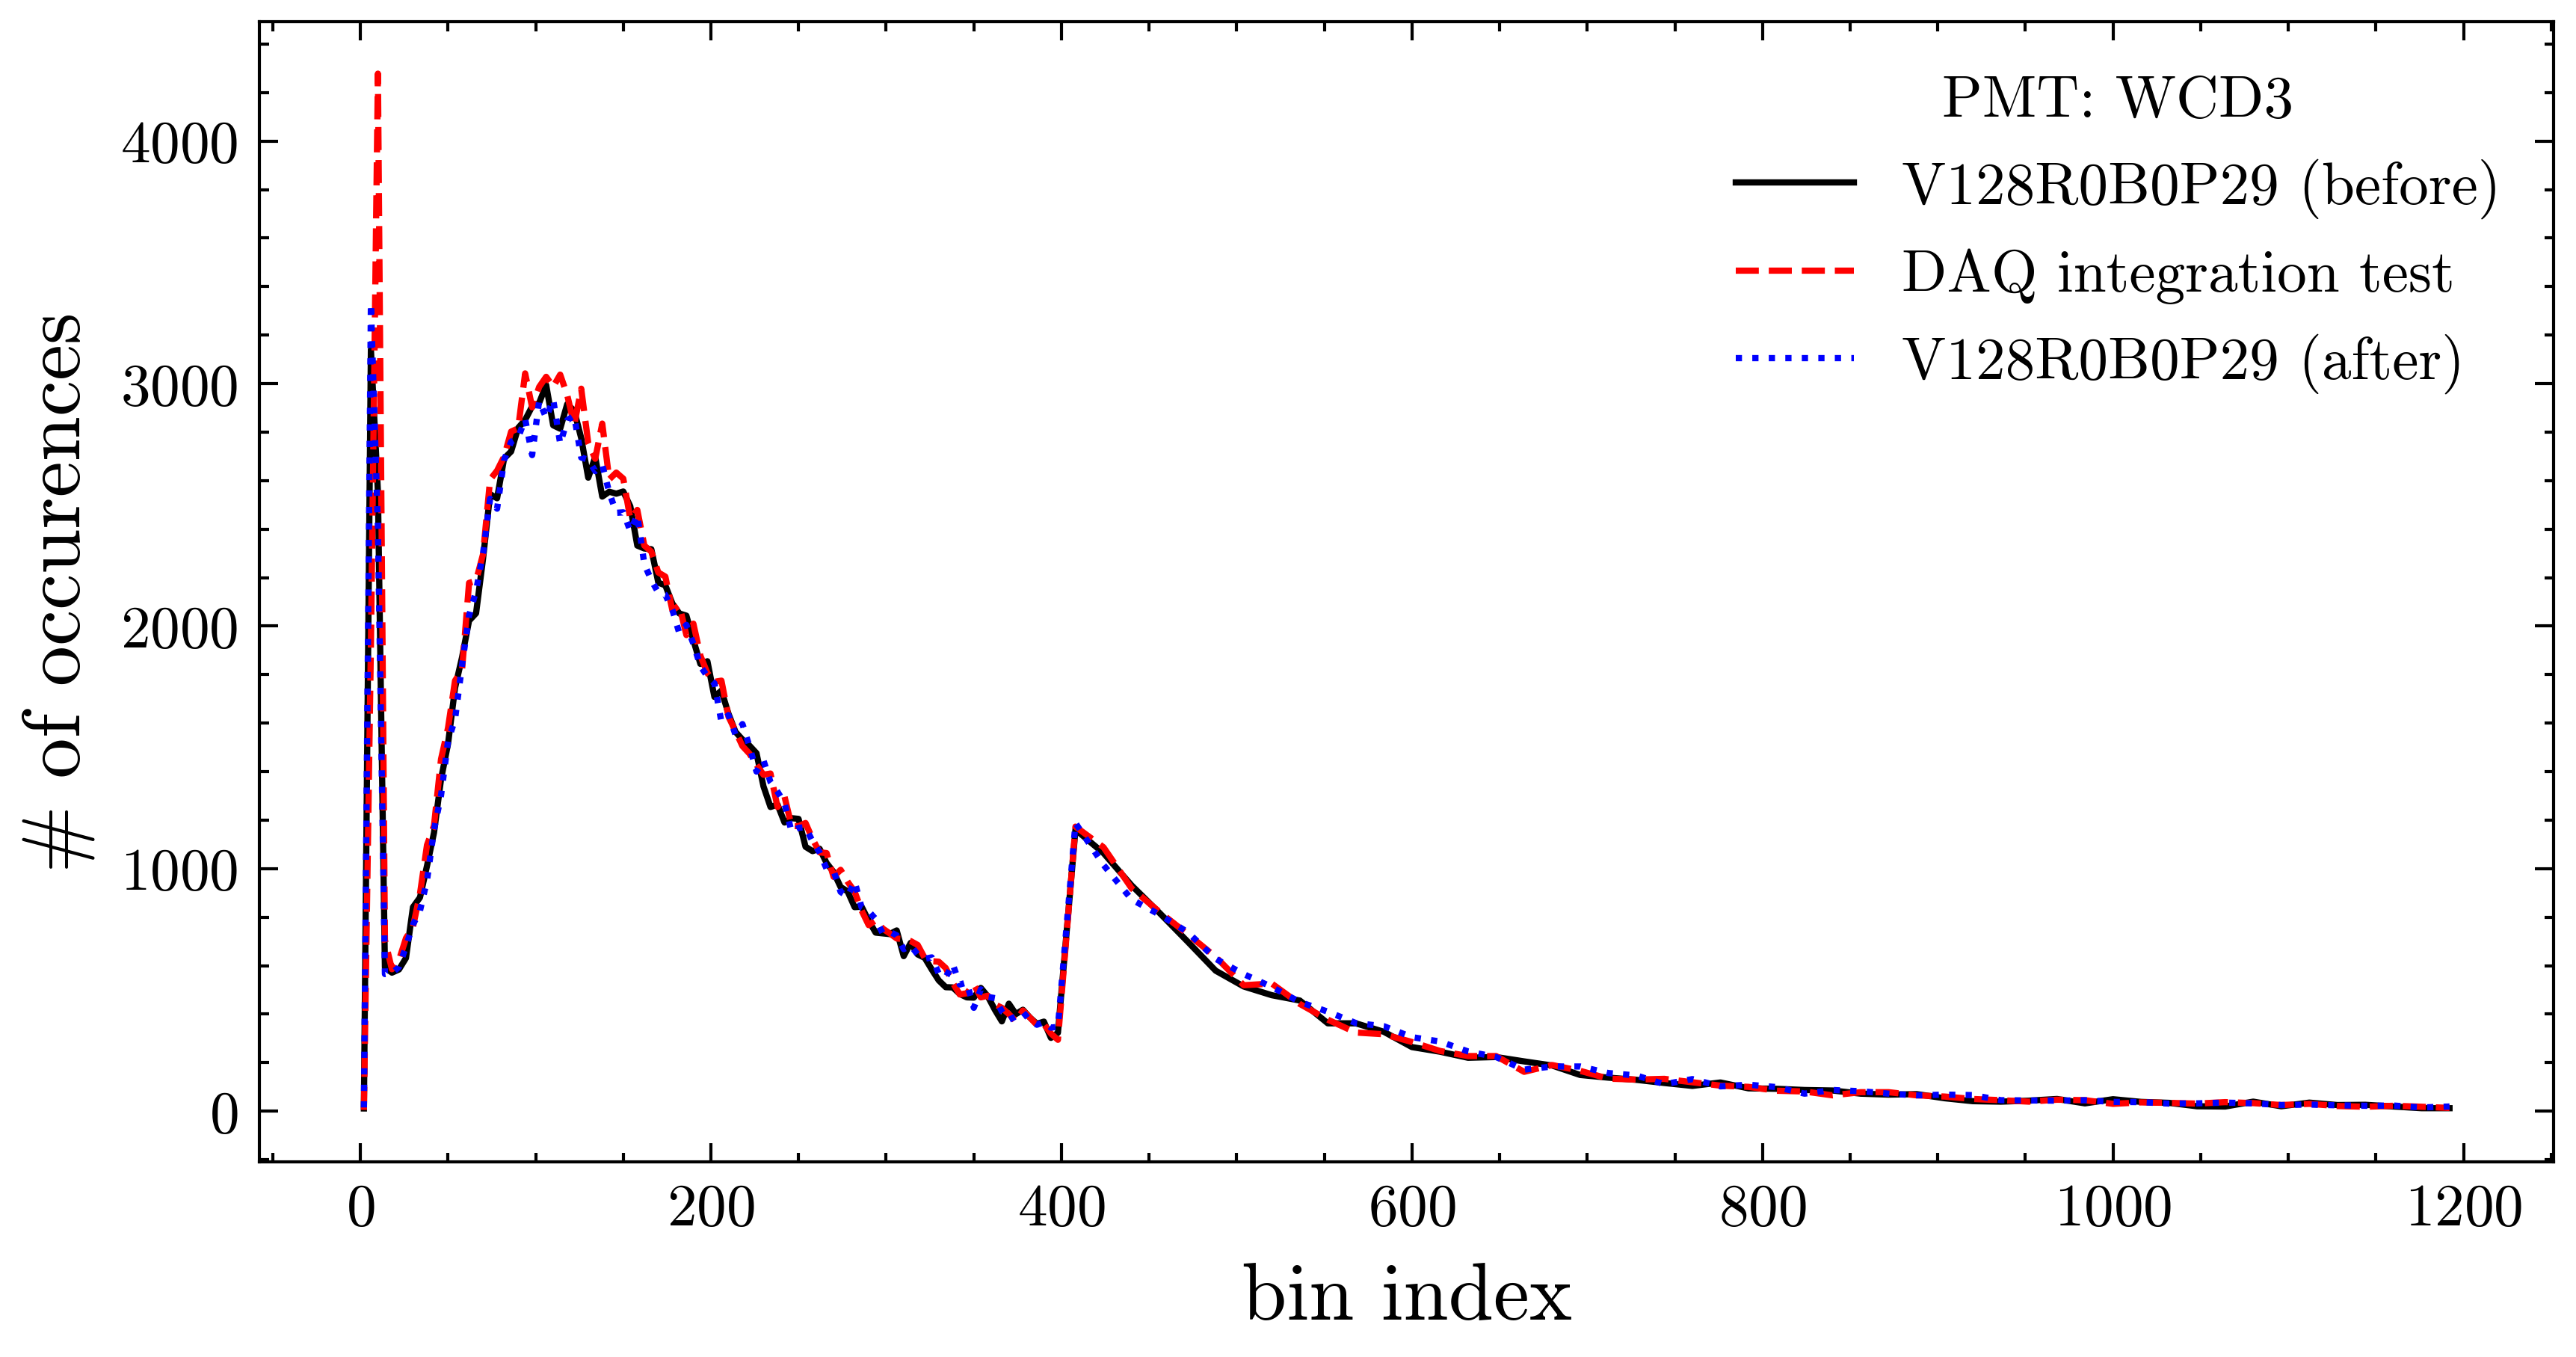

In [8]:

title = ['SSD', 'WCD1', 'WCD2', 'WCD3']
for xxx, histo in zip(title, [ssds_histos, wcd1_histos, wcd2_histos, wcd3_histos]):

    ix = 15 if xxx != 'WCD1' else 14
    histo = histo.select('histo').to_numpy()
    BINS = CONSTANTS.UUB_WCD_BIN_CENTERS if xxx != 'SSD' else CONSTANTS.UUB_SSD_BIN_CENTERS

    plt.figure()
    plt.plot(BINS, histo[1][0], label='V128R0B0P29 (before)')
    plt.plot(BINS, histo[ix][0], label='DAQ integration test')
    plt.plot(BINS, histo[-1][0], label='V128R0B0P29 (after)')

    plt.ylabel('# of occurences')
    plt.xlabel('bin index')
    plt.legend(title=f"PMT: {xxx}")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


vem = 220.8


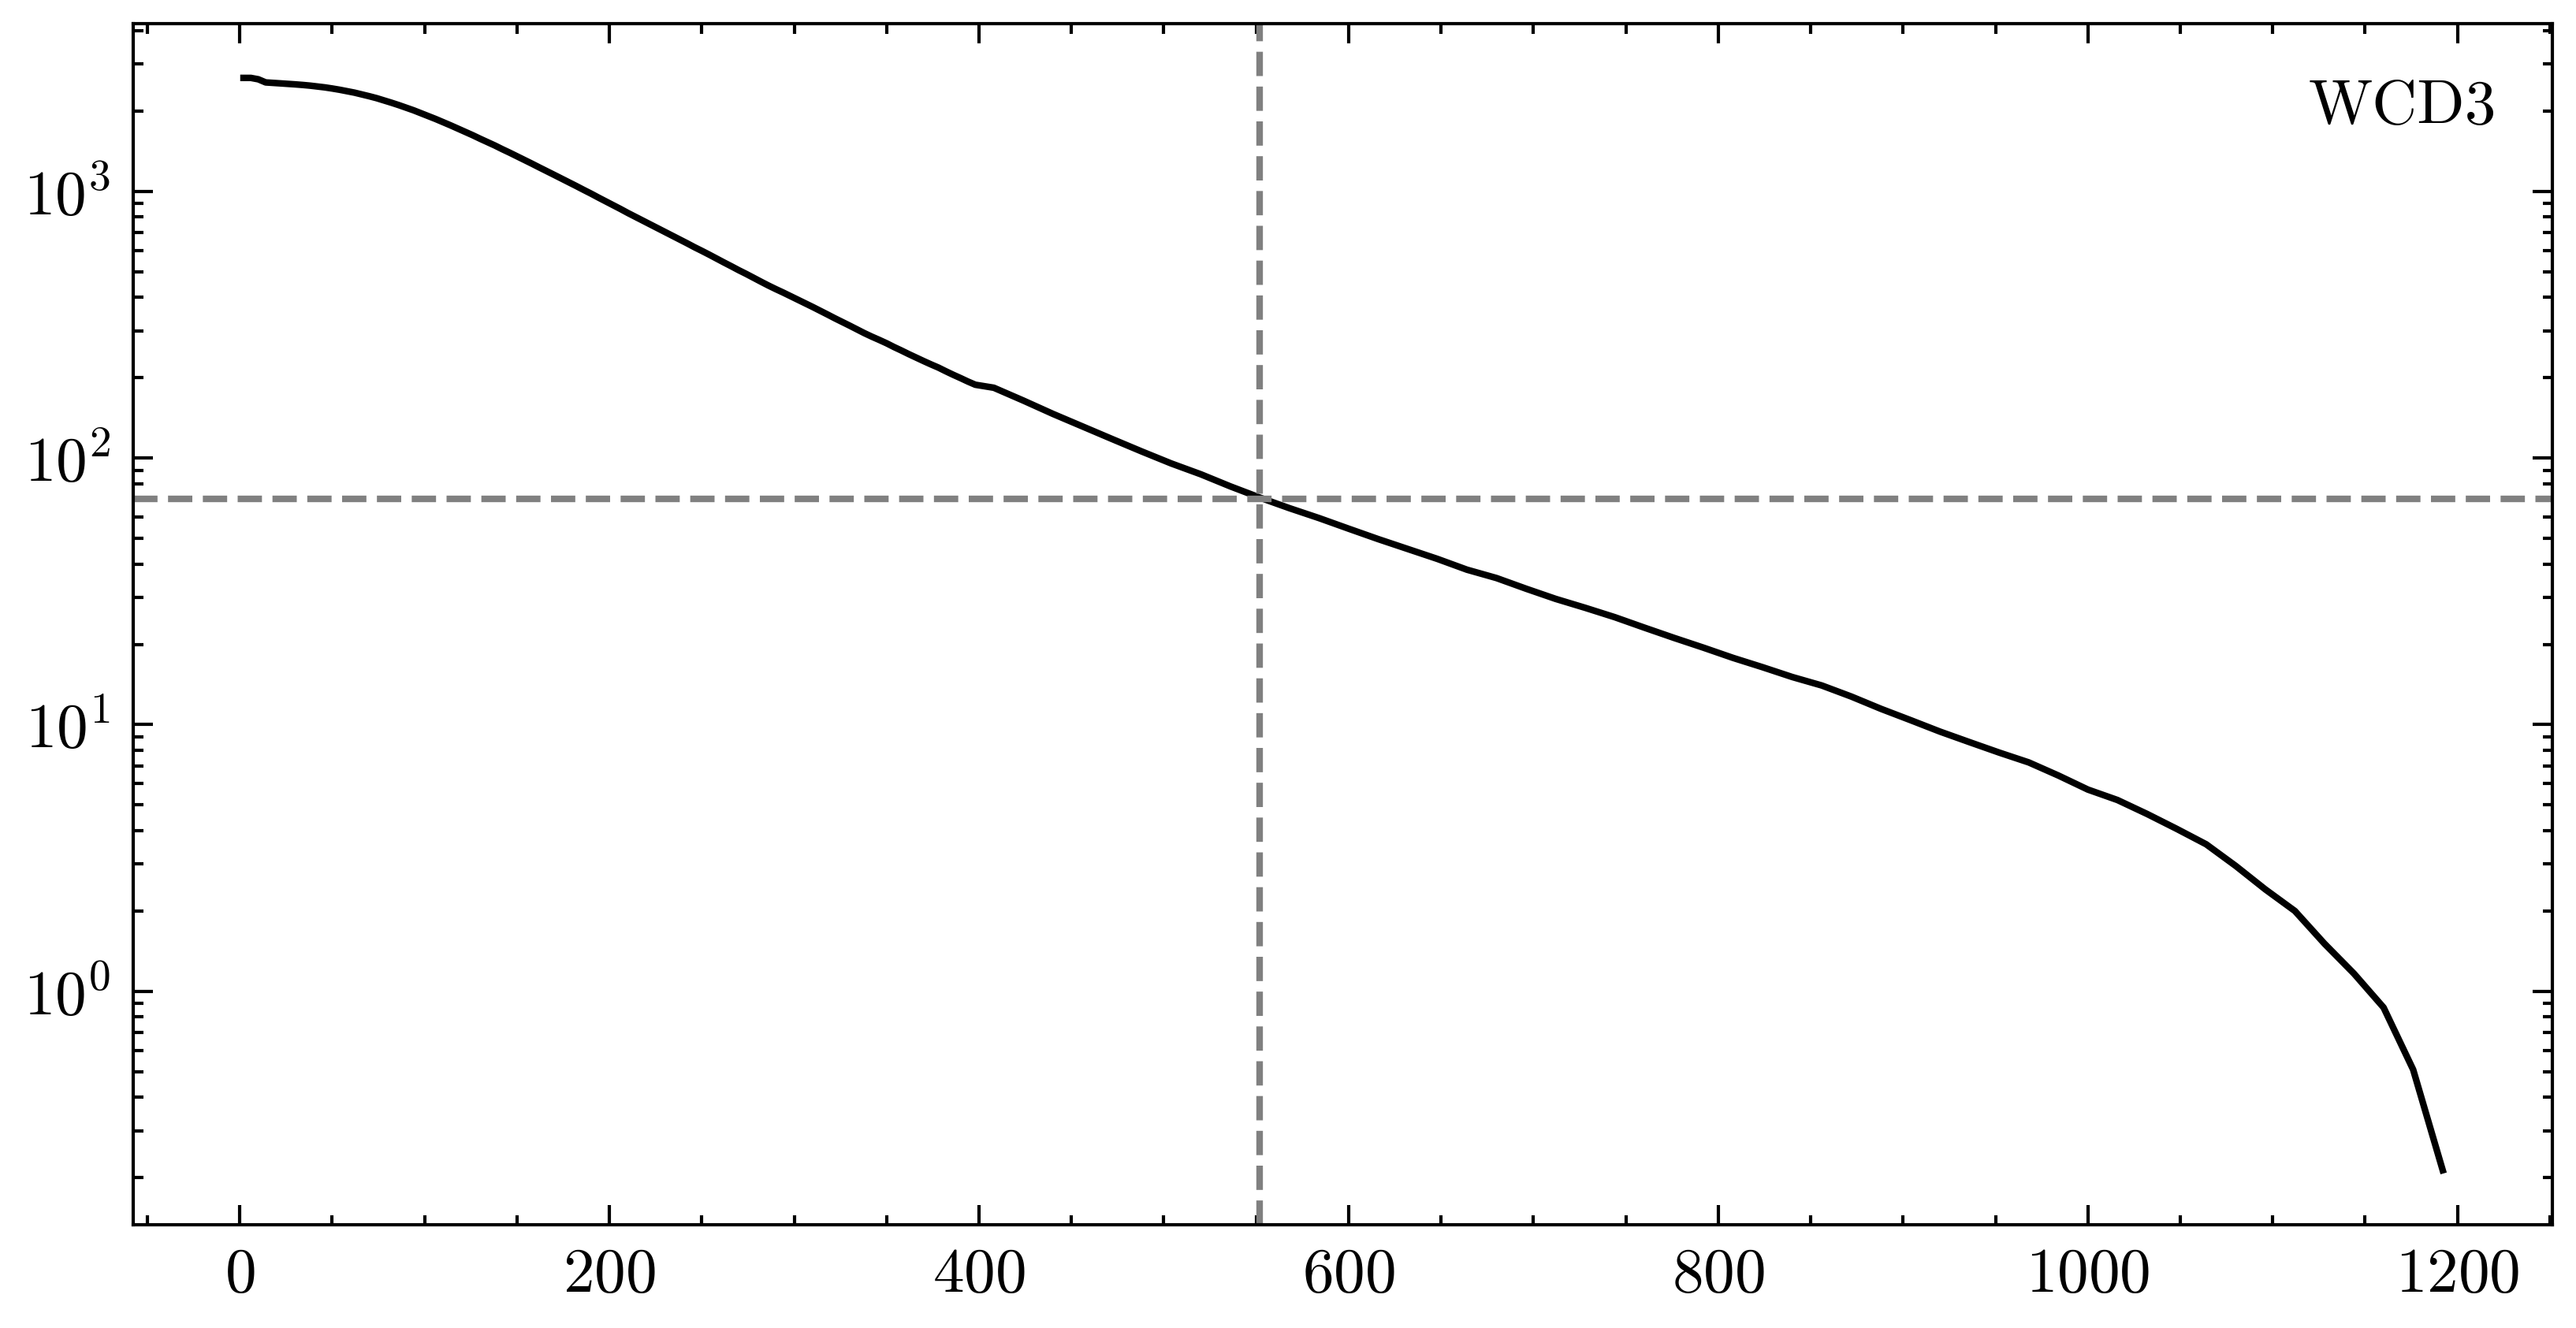

In [17]:
rates = np.cumsum(histo[ix][0][::-1])[::-1] / 61
vem = BINS[np.argmin(abs(70 - rates))]

plt.plot(BINS, rates)
plt.axhline(70, c='gray', ls='--')
plt.axvline(vem, c='gray', ls='--')
plt.yscale('log')

print(f"vem = {vem/2.5}")

plt.legend(title=xxx)